In [2]:
import torch, torch.nn as nn
import numpy as np, matplotlib.pyplot as plt
from tqdm.auto import tqdm

def seq_mlp(init, mlp, fin, act):
    modules = [nn.Linear(init, mlp[0]), act]
    for i in range(len(mlp) - 1):
        modules.append(nn.Linear(mlp[i], mlp[i+1]))
        modules.append(act)

    modules.append(nn.Linear(mlp[-1], fin)) #self.spl for spline

    return modules

def nan_hook(self, inp, output):
    if not isinstance(output, tuple):
        outputs = [output]
    else:
        outputs = output

    for i, out in enumerate(outputs):
        nan_mask = torch.isnan(out)
        if nan_mask.any():
            print(outputs)
            print("In ", self.__class__.__name__)
            raise RuntimeError(f"Found NAN in output {i}")

c:\Users\Hanse Kim\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
class EvalEig(nn.Module):
    def __init__(self, eval_para):
        super().__init__()
        self.rn = eval_para['r_dsc']
        self.rm = eval_para['r_infty']
        self.ln = eval_para['l_max']+1
        self.para = eval_para

        # l x r
        self.r_dsc = torch.linspace(self.rm/self.rn, self.rm, self.rn)
        self.l_dsc = torch.arange(0,self.ln, dtype = torch.int).view(1,-1,1,1)
        r_red = torch.linspace(1/self.rn, 1, self.rn).view(1,-1)

        r_dsc_tay_pre = r_red.expand(eval_para['pw'],-1)/torch.arange(1,eval_para['pw']+1).view(-1,1)
        r_dsc_tay = torch.cumprod(r_dsc_tay_pre,dim=0)
        self.r_dsc_pw = torch.cat((1/r_red, r_dsc_tay), dim=0)
    
    def dsc_eigs(self, ptl):
        dsc_lap = (-2*torch.eye(self.rn) + torch.diag(torch.ones(self.rn-1),1) + torch.diag(torch.ones(self.rn-1),-1))*(self.rn/self.rm)**2
        dsc_lap = dsc_lap.view(1, 1, self.rn, self.rn)
        dsc_ptl = torch.diag_embed(ptl).view(ptl.shape[0],1,self.rn,self.rn)
        dsc_eff = self.l_dsc*(self.l_dsc+1)*torch.diag(1/self.r_dsc**2).view(1, 1, self.rn,self.rn)
        
        dsc_hmt = (-self.para['para_0']*dsc_lap + dsc_ptl + self.para['para_0']*dsc_eff)

        #print(dsc_hmt)

        evl, _ = torch.linalg.eigh(dsc_hmt)
        # bound state condition
        # evl[evl>0] = torch.tensor(0)

        return evl

class InvEig(EvalEig):
    def __init__(self, clip_size, eval_para, model_para):
        super().__init__(eval_para)
        # model
        #modules = seq_mlp(init = clip_size*self.ln, mlp = model_para['mlp'],
        modules = seq_mlp(init = self.rn, mlp = model_para['mlp'],
                          fin = eval_para['pw'] + 1, act = nn.ReLU())
        self.mlp = nn.Sequential(*modules)


    def forward(self, energy):
        # obtain potential via model
        # via mlp
        #input_layer = energy.reshape(energy.shape[0],energy.shape[1]*energy.shape[2])
        input_layer = self.r_dsc.view(1,-1).expand(self.para['batch_dim'], -1)
        coeffs_temp = self.mlp(input_layer)
        coeffs = torch.cat((-torch.abs(coeffs_temp[:,:1]),coeffs_temp[:,1:]),dim=1)

        ptl_md = coeffs @ self.r_dsc_pw

        # calculate learned energy
        #evl_md = self.dsc_eigs(ptl_md)

        return ptl_md, _, coeffs

In [14]:
eval_para = {
        # evaluation model
        'r_infty' : 40, # high r_infty maintains V(infty) ~ 0
        'r_dsc' : 1000, # computation time vs accuracy; maintain delta r ~ 0
        'l_max' : 0, # maximum l_max to evaluate radial schrodinger upto
        
        # potential specifics
        'ptl_form' : 'coulomb',
        'para_0' : 1, # hbar^2/2m
        'para_1' : 1, # scales energy; scales horizontally (r_rat) and modelwise (r_dsc)

        # model specifics
        'precision' : 64, # 32 or 64 bit
        'pw' : 50, # consider 1/r and up to r^n
        'batch_dim' : 1,
        }

model_para = {
        # model
        'mlp' : [100, 100, 100],

        # training
        'epoch' : 4000,
        'lr' : 1e-3,

        # loss regularisation
        'reg1' : 1e-1, # smoothness
        
        }

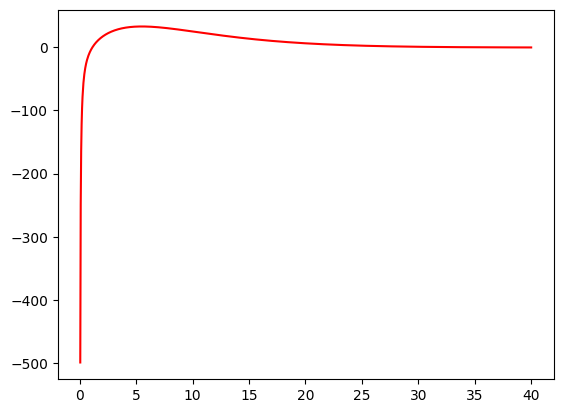

In [15]:
eval = EvalEig(eval_para)#.to(device)

coeffs_tr = torch.rand(eval_para['batch_dim'], eval_para['pw']+1)*eval_para['para_1']
coeffs_tr[:,0] = -torch.abs(coeffs_tr[:,0])
#coeffs_tr[:,1:] = torch.tensor([0])
coeffs_tr[:,1:] = coeffs_tr[:,1:]*10 - 5

ptl_tr = coeffs_tr @ eval.r_dsc_pw
ptl_tr = (-20/eval.r_dsc + 100*torch.exp(-eval.r_dsc/5)*eval.r_dsc/5).view(1,-1)
plt.plot(eval.r_dsc, ptl_tr[0], label='true', color = 'red')

In [16]:
evl_tr = eval.dsc_eigs(ptl_tr)

In [17]:
clip_size = evl_tr[evl_tr < 0].shape[0] // (eval_para['batch_dim']*(eval_para['l_max']+1)) - 5
print(clip_size)
clip_size = 10
#print(evl_tr[0,0,0]/evl_tr[:,:,:])

-3


In [18]:
model = InvEig(clip_size, eval_para, model_para)

In [19]:
#for submodule in model.modules():
#    submodule.register_forward_hook(nan_hook)
optimiser = torch.optim.Adam(model.parameters(), lr = model_para['lr'])
epochs = model_para['epoch']
pbar = tqdm(range(epochs), desc='Progress', total=epochs, leave = True, position=0, colour='blue')
loss_list = [[]]

for e in range(epochs):
    #ptl_md, evl_md = model(hp['true'])
    #with torch.autograd.detect_anomaly():
    
    ptl_md, _, coeffs_md = model(evl_tr[:,:,:clip_size])
    #loss = nn.L1Loss()(evl_tr[:,:,:clip_size], evl_md[:, :,:clip_size])
    loss = nn.L1Loss()(ptl_md, ptl_tr)

    if e == 0:
        ptl_init = ptl_md

    loss_list[0].append(loss.item())

    #print(loss_0.item(), loss.item())

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

    pbar.update()

Progress: 100%|█████████▉| 3990/4000 [00:17<00:00, 274.28it/s]

In [20]:
torch.save(model.state_dict(), f"{eval_para['batch_dim']}_{eval_para['pw']}.pth")
#model.load_state_dict(torch.load('.pth'))

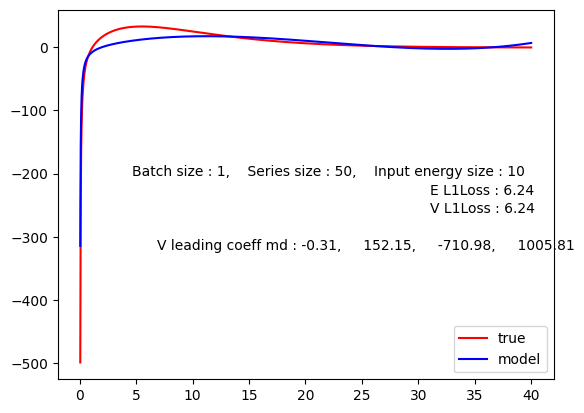

In [22]:
plt.figure()
i = 0
plt.plot(eval.r_dsc, ptl_tr[i], label='true', color = 'red')
#plt.plot(eval.r_dsc, ptl_init[i].squeeze(0).detach(), label='model_i', color = 'green')
plt.plot(eval.r_dsc, ptl_md[i].squeeze(0).detach(), label='model', color = 'blue')
plt.legend()
plt.annotate(f"Batch size : {eval_para['batch_dim']},\
    Series size : {eval_para['pw']},\
    Input energy size : {clip_size}", xy = {0.15, 0.55}, xycoords="axes fraction")
plt.annotate(f"E L1Loss : {loss:.2f}", xy = (0.75, 0.5), xycoords="axes fraction")
plt.annotate(f"V L1Loss : {nn.L1Loss()(ptl_tr[i], ptl_md[i]).item():.2f}", xy = (0.75, 0.45), xycoords="axes fraction")
plt.annotate(f"V leading coeff md : {coeffs_md[i,0].item():.2f}, \
    {coeffs_md[i,1].item():.2f}, \
    {coeffs_md[i,2].item():.2f}, \
    {coeffs_md[i,3].item():.2f}", xy = (0.2, 0.35), xycoords="axes fraction")
#plt.annotate(f"V leading coeff tr : {coeffs_tr[i,0].item():.2f}, \
#    {coeffs_tr[i,1].item():.2f}, \
#    {coeffs_tr[i,2].item():.2f}, \
#    {coeffs_tr[i,3].item():.2f}", xy = (0.25, 0.4), xycoords="axes fraction")
plt.savefig(f"{eval_para['batch_dim']}_{eval_para['pw']}_{i}ptl.png")

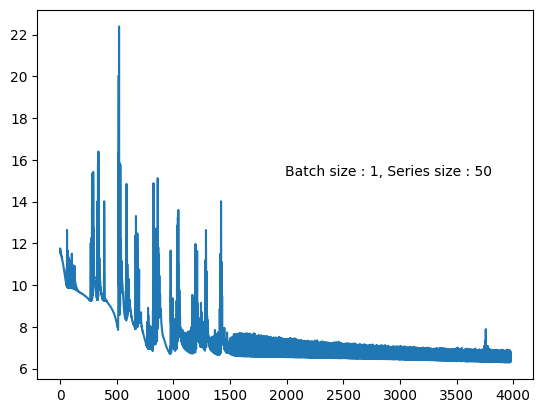

Progress: 100%|██████████| 4000/4000 [00:32<00:00, 276.21it/s]

: 

In [130]:
plt.figure()
j = 20
plt.plot(range(epochs-j), loss_list[0][j:])
plt.annotate(f"Batch size : {eval_para['batch_dim']}, Series size : {eval_para['pw']}", xy = {0.5, 0.55}, xycoords="axes fraction")
plt.savefig(f"{eval_para['batch_dim']}_{eval_para['pw']}_loss.png")

In [26]:
print((evl_tr[:,:,:clip_size]-evl_md[:, :,:clip_size])/evl_tr[:,:,:clip_size])
print(evl_tr[:,:,:clip_size])

tensor([[[-2.7505e-01, -2.9895e-01, -3.0417e-01,  ..., -2.3673e-01,
          -2.0457e-01, -1.6533e-01]],

        [[-3.5497e-02, -3.6907e-02, -3.8610e-02,  ..., -2.0508e-01,
          -3.0134e-01, -4.7094e-01]],

        [[ 3.6381e-01,  2.2029e-01,  1.5601e-01,  ..., -1.3763e-01,
          -1.9188e-01, -2.3317e-01]],

        ...,

        [[ 1.1965e+00,  1.3362e+01, -8.0354e-01,  ..., -1.8614e-02,
          -1.2826e-02, -1.0361e-02]],

        [[ 2.2280e-01, -1.6858e-01, -3.5333e-02,  ...,  6.2180e-01,
           3.1239e-01,  1.9734e-01]],

        [[-1.1397e-01, -1.1613e-01, -1.1820e-01,  ..., -5.6340e-01,
          -9.4748e-01, -1.3308e+00]]], grad_fn=<DivBackward0>)
tensor([[[-2.8252e+02, -7.6304e+01, -3.4512e+01,  ..., -4.3050e+00,
          -3.6691e+00, -3.2377e+00]],

        [[-1.0403e+02, -2.6803e+01, -1.1985e+01,  ..., -1.3450e+00,
          -1.0958e+00, -9.1976e-01]],

        [[ 4.2922e-01,  8.0475e-01,  1.0861e+00,  ...,  2.0549e+00,
           2.1438e+00,  2.2464e+00]],


tensor([[[-1.5899e+01, -3.9935e+00, -1.7765e+00, -9.9954e-01, -6.3979e-01,
          -4.4436e-01, -3.2648e-01, -2.4932e-01, -1.8511e-01, -1.0957e-01,
          -1.5352e-02]]])


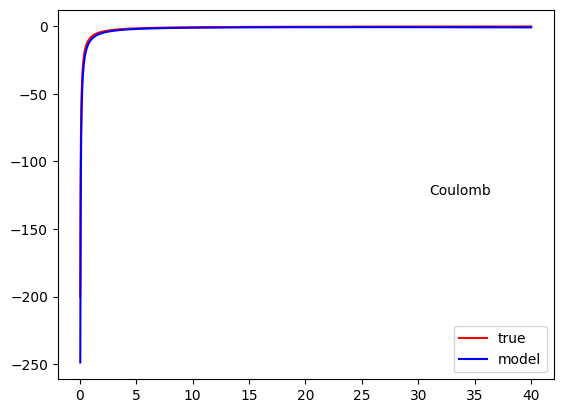

In [27]:
# robustness test
ptl_tr_coulomb = -8/eval.r_dsc

evl_tr_coulomb = eval.dsc_eigs(ptl_tr_coulomb.reshape(1,1,eval.rn))
print(evl_tr_coulomb[:,:,:clip_size])
ptl_md_coulomb, evl_md_coulomb = model(evl_tr_coulomb[:,:,:clip_size])

plt.plot(eval.r_dsc, ptl_tr_coulomb, label='true', color = 'red')
#plt.plot(eval.r_dsc, ptl_init[i].squeeze(0).detach(), label='model_i', color = 'green')
plt.plot(eval.r_dsc, ptl_md_coulomb.squeeze(0).detach(), label='model', color = 'blue')
plt.annotate(f"Coulomb", xy = (0.75, 0.5), xycoords="axes fraction")
plt.legend()

tensor([[[-9.2136e+00, -1.0648e-01,  7.6168e-03,  3.0698e-02,  6.8330e-02,
           1.1988e-01,  1.8491e-01,  2.6315e-01,  3.5446e-01,  4.5871e-01,
           5.7584e-01]]])


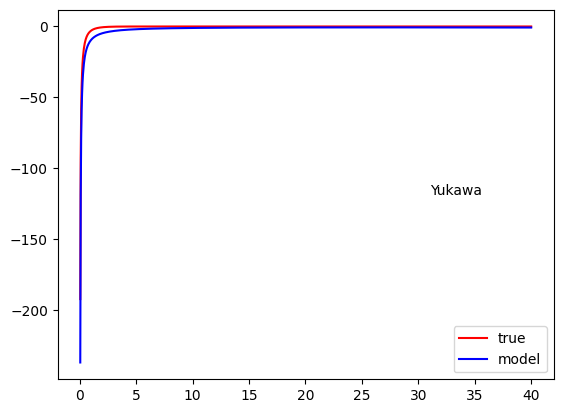

In [28]:
# robustness test
ptl_tr_yukawa = -8*torch.exp(-eval.r_dsc)/eval.r_dsc

evl_tr_yukawa = eval.dsc_eigs(ptl_tr_yukawa.reshape(1,1,eval.rn))
print(evl_tr_yukawa[:,:,:clip_size])
ptl_md_yukawa, evl_md_yukawa = model(evl_tr_yukawa[:,:,:clip_size])

plt.plot(eval.r_dsc, ptl_tr_yukawa, label='true', color = 'red')
#plt.plot(eval.r_dsc, ptl_init[i].squeeze(0).detach(), label='model_i', color = 'green')
plt.plot(eval.r_dsc, ptl_md_yukawa.squeeze(0).detach(), label='model', color = 'blue')
plt.annotate(f"Yukawa", xy = (0.75, 0.5), xycoords="axes fraction")
plt.legend()

tensor([[[0.1099, 0.2526, 0.3749, 0.4862, 0.5856, 0.6153, 0.6810, 0.7649,
          0.8597, 0.9697, 1.0935]]])
tensor([[[-1.8120, -0.3520,  0.0261,  0.2551,  0.4391,  0.6029,  0.7555,
           0.9012,  1.0423,  1.1801,  1.3157]]], grad_fn=<SliceBackward0>)


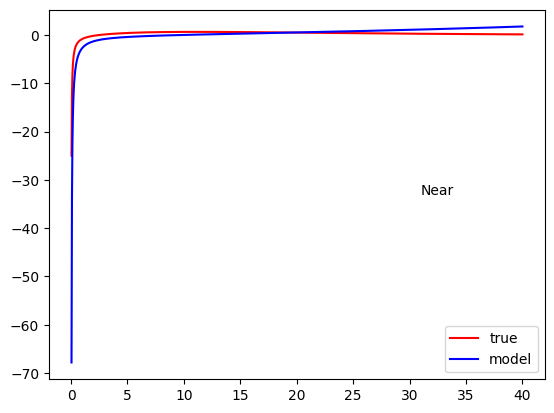

In [36]:
# robustness test
ptl_tr_near = -1/eval.r_dsc + 2*torch.exp(-eval.r_dsc/10)*eval.r_dsc/10

evl_tr_near = eval.dsc_eigs(ptl_tr_near.reshape(1,1,eval.rn))
print(evl_tr_near[:,:,:clip_size])
ptl_md_near, evl_md_near = model(evl_tr_near[:,:,:clip_size])
print(evl_md_near[:,:,:clip_size])
plt.plot(eval.r_dsc, ptl_tr_near, label='true', color = 'red')
#plt.plot(eval.r_dsc, ptl_init[i].squeeze(0).detach(), label='model_i', color = 'green')
plt.plot(eval.r_dsc, ptl_md_near.squeeze(0).detach(), label='model', color = 'blue')
plt.annotate(f"Near", xy = (0.75, 0.5), xycoords="axes fraction")
plt.legend()

tensor([[[-16.7143,  -9.0144,  -7.7100,  -6.7335,  -5.9382,  -5.2662,  -4.8577,
           -4.6870,  -4.1819,  -3.7386,  -3.3483]]])


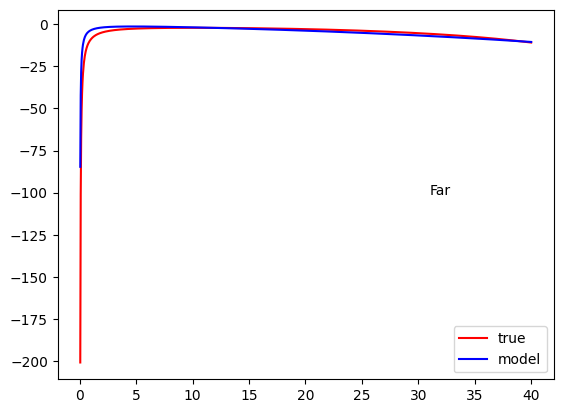

In [31]:
# robustness test
ptl_tr_far = -8/eval.r_dsc*torch.exp(eval.r_dsc/10)

evl_tr_far = eval.dsc_eigs(ptl_tr_far.reshape(1,1,eval.rn))
print(evl_tr_far[:,:,:clip_size])
ptl_md_far, evl_md_far = model(evl_tr_far[:,:,:clip_size])

plt.plot(eval.r_dsc, ptl_tr_far, label='true', color = 'red')
#plt.plot(eval.r_dsc, ptl_init[i].squeeze(0).detach(), label='model_i', color = 'green')
plt.plot(eval.r_dsc, ptl_md_far.squeeze(0).detach(), label='model', color = 'blue')
plt.annotate(f"Far", xy = (0.75, 0.5), xycoords="axes fraction")
plt.legend()